# Exercises on uninformed search and Homework 1 

**Last time**
- Informed search
- Heuristics
- Best First search
- Hill climbing
- A*
- Homework - heuristic for the homework

An important slide from Bobby's materials: 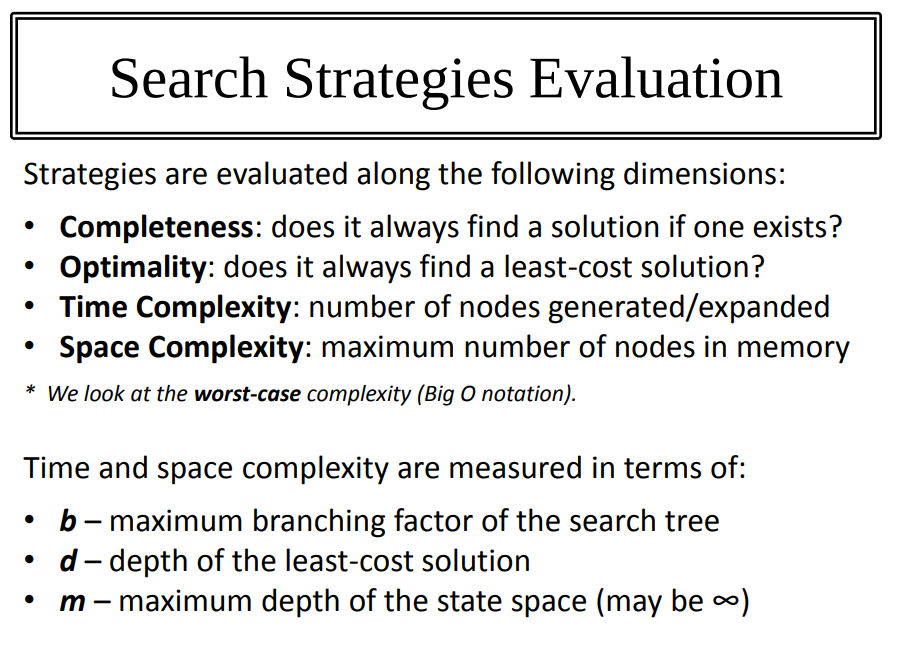

**This time**

- Solving homework 0 (Frogs)
- Uniform cost search
- Depth limited search
- Iterative deepening search

## Utilities

In [15]:
from dataclasses import dataclass
from typing import Any
from collections import defaultdict

import heapq
from IPython.display import clear_output

@dataclass
class Node:
    value: Any = 'no'
    heuristic: float = 0
    color: str = 'black'


@dataclass
class Graph:
    nodes: Any
    edges: Any
    undirected_edges: Any

    def children_of(self, node_value):
        return [(self.nodes[v], w) for v, w in self.undirected_edges[node_value]]


def make_graph(nodes, edges):
    nodes = {v: Node(value=v, heuristic=h) for v, h in nodes}
    
    undirected_edges = defaultdict(list)
    for node, children in edges.items():
        for child, weight in children:
            undirected_edges[node].append((child, weight))
            undirected_edges[child].append((node, weight))
    
    return Graph(nodes=nodes, edges=edges, undirected_edges=undirected_edges)

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import time


def draw_spring_graph(graph, seed=1, figsize=(8, 8)):
    nodes = graph.nodes.values()
    edges = []
    for node, children in graph.edges.items():
        for c, weight in children:
            edges.append((node, c, weight))
        
    G = nx.Graph()
    for n in nodes:
        G.add_node(n.value)

    for f, t, _ in edges:
        G.add_edge(f, t)

    pos = nx.spring_layout(G, seed=seed)

    plt.figure(figsize=figsize)

    nx.draw_networkx_edges(G, pos, alpha=1, width=3)
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=[n.value for n in nodes],
        node_size=1500,
        node_color=[n.color for n in nodes],
    )
    nx.draw_networkx_labels(
        G,
        pos,
        labels={n.value: f'{n.value}({n.heuristic})' for n in nodes},
        font_size=12,
        font_color='white',
        font_weight='bold'
    )

    edge_labels = dict([((n1, n2), f'{w}') for n1, n2, w in edges])
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, 
    label_pos=0.5,
    font_size=15)

    # Set margins for the axes so that nodes aren't clipped

    ax = plt.gca()
    ax.margins(0.1)
    plt.axis("off")
    plt.show()


def display_graph(g, current, end, front, visited):
    front_set = {v for w, v in front}
    for _, node in g.nodes.items():
        node.color = 'black'
        if node.value in front_set:
            node.color = 'red'
        if node.value in visited:
            node.color = 'blue'
        if node.value == current:
            node.color = 'orange'
        if node.value == end:
            node.color = 'green'
        
    draw_spring_graph(g, seed=100, figsize=(16, 10))

## Examples

In [20]:
g = make_graph(
    nodes=[('A', 0), ('B', 0), ('C', 0), ('D', 0), ('S', 0), ('G', 0)],
    edges={
        'S': [('C', 14), ('B', 9), ('A', 7)],
        'A': [('B', 10), ('D', 15)],
        'B': [('C', 2), ('D', 11)],
        'C': [('G', 9)],
        'D': [('G', 6)],
    }
)

In [21]:
g.nodes['S'].color = 'orange'
g.nodes['G'].color = 'green'

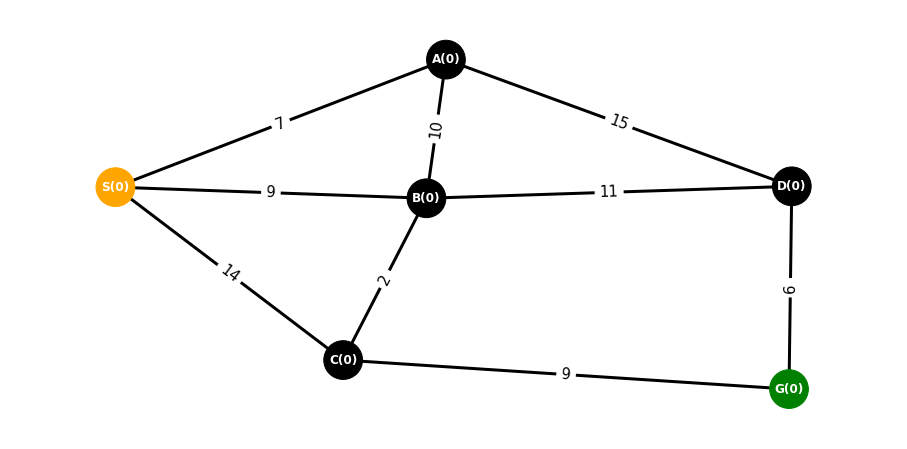

In [22]:
draw_spring_graph(g, seed=100, figsize=(16, 8))

### Frogs Homework

In [83]:
def get_start_state(n):
    return '>' * n + '_' + '<' * n


def get_end_state(n):
    return '<' * n + '_' + '>' * n


def get_next_states(state):
#     >_ -> _>
#     _< -> <_
#     >*_ -> _*>
#         >>_ -> _>>
#         ><_ -> _<>
#     _*< -> <*_
#         _<< -> <<_
#         _>< -> <>_
    next_states = [
        state.replace('>_', '_>'),
        state.replace('_<', '<_'),
        state.replace('>>_', '_>>'),
        state.replace('><_', '_<>'),
        state.replace('_<<', '<<_'),
        state.replace('_><', '<>_'),
    ]
    s = set(next_states)
    s.remove(state)
    return s


def reconstruct_path(parent_of, end_state):
    current = end_state
    path = [current]
    while current in parent_of:
        current = parent_of[current]
        path.append(current)
        
    return path[::-1]


def solve_leaping_frongs(n):
    start_state = get_start_state(n)
    end_state = get_end_state(n)
    parent_of = {}
    
    stack = [start_state]
    while len(stack) > 0:
        current_state = stack.pop()

        if current_state == end_state:
            return reconstruct_path(parent_of, end_state)

        for child_state in get_next_states(current_state):
            stack.append(child_state)
            parent_of[child_state] = current_state

In [89]:
solve_leaping_frongs(2)

['>>_<<',
 '>_><<',
 '><>_<',
 '><><_',
 '><_<>',
 '_<><>',
 '<_><>',
 '<<>_>',
 '<<_>>']

In [96]:
def uniform_cost_search(g, start, end):
    start_node = g.nodes[start]
    queue = [(start_node.heuristic, start)]
    visited = set()
    distances = {start: 0}

    while len(queue) > 0:
        _, current = heapq.heappop(queue)
        current_node = g.nodes[current]
        
        if current == end:
            print('done!')
            return
        
        if current in visited:
            continue
        visited.add(current)
        
        for child_node, weight in g.children_of(current):
            if child_node.value in visited:
                continue
                
            distance_to_child = distances[current] + weight
            if child_node.value in distances:
                best_distance = min(distances[child_node.value], distance_to_child)
                distances[child_node.value] = best_distance
#                 queue = relax_element(queue, ())
            else:
                distances[child_node.value] = distance_to_child

            f = child_node.heuristic + distance_to_child
            heapq.heappush(queue, (f, child_node.value))

#         clear_output()
        print(current, visited, queue)
        display_graph(g, current, end, queue, visited)
#         time.sleep(3)

In [98]:
# uniform_cost_search(g, 'S', 'G')

## Depth limited search

In [109]:
def dfs(g, start, end):
    stack = [start]
    visited = set()
    parent_of = {}
    
    while len(stack):
        current = stack.pop()

        if current in visited:
            continue
        visited.add(current)
            
        if current == end:
            return reconstruct_path(parent_of, end)
        
        for child_node, _ in g.children_of(current):
            if child_node.value in visited:
                continue

            parent_of[child_node.value] = current                
            stack.append(child_node.value)

In [110]:
dfs(g, 'S', 'G')

['S', 'A', 'D', 'G']

In [137]:
def depth_limited_search(g, start, end, max_depth):
    visited = set()
    parent_of = {}

    def dfs(current, depth=0):
        if current in visited or depth > max_depth:
            return
        visited.add(current)

        if current == end:
            return reconstruct_path(parent_of, end)

        for child_node, _ in g.children_of(current):
            if child_node.value in visited:
                continue

            parent_of[child_node.value] = current
            path = dfs(child_node.value, depth=depth + 1)
            if path is not None:
                return path

        return None
            
    return dfs(start)

In [138]:
path = depth_limited_search(g, 'S', 'G', max_depth=1)
print(path)

None


In [142]:
def iterative_deepening(g, start, end):
    for i in range(10000000):
        path = depth_limited_search(g, start, end, max_depth=i)
        if path is not None:
            print(i)
            return path

In [143]:
iterative_deepening(g, 'S', 'G')

2


['S', 'C', 'G']